In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Install required libraries
!pip install geopandas shapely openpyxl

In [17]:
from google.colab import files
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

print("Please upload ALL 6 shapefile files:")
print("- statistical_areas_2022.shp")
print("- statistical_areas_2022.shx")
print("- statistical_areas_2022.dbf")
print("- statistical_areas_2022.prj")
print("- statistical_areas_2022.cpg")
print("- statistical_areas_2022.xml")
print()

uploaded = files.upload()

Please upload ALL 6 shapefile files:
- statistical_areas_2022.shp
- statistical_areas_2022.shx
- statistical_areas_2022.dbf
- statistical_areas_2022.prj
- statistical_areas_2022.cpg
- statistical_areas_2022.xml



Saving statistical_areas_2022.cpg to statistical_areas_2022.cpg
Saving statistical_areas_2022.dbf to statistical_areas_2022.dbf
Saving statistical_areas_2022.prj to statistical_areas_2022.prj
Saving statistical_areas_2022.shp to statistical_areas_2022.shp
Saving statistical_areas_2022.shx to statistical_areas_2022.shx
Saving statistical_areas_2022.xml to statistical_areas_2022.xml


In [18]:
print("\n" + "="*80)
print("Loading shapefile...")

try:
    # Load the shapefile
    gdf_areas = gpd.read_file('statistical_areas_2022.shp')

    print(f"✓ Successfully loaded shapefile")
    print(f"✓ Total statistical areas: {len(gdf_areas)}")
    print(f"✓ CRS: {gdf_areas.crs}")

    print("\n" + "="*80)
    print("Columns in shapefile:")
    print(gdf_areas.columns.tolist())

    print("\n" + "="*80)
    print("Checking all statistical area codes...")

    # Find the column name for stat_2022 (might be STAT_2022 or stat_2022)
    stat_col = None
    for col in gdf_areas.columns:
        if 'stat' in col.lower() and '2022' in col.lower():
            stat_col = col
            break

    if stat_col:
        all_stats = sorted(gdf_areas[stat_col].unique())
        print(f"\nFound {len(all_stats)} unique statistical areas:")
        print(all_stats)

        # Check if we have all expected areas
        expected = [11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 31, 32, 33, 41, 42, 43, 44, 45, 46, 47]
        missing = [s for s in expected if s not in all_stats]

        if len(all_stats) == 25:
            print(f"\n✓✓✓ SUCCESS! All 25 statistical areas loaded!")
        else:
            print(f"\n⚠ Warning: Expected 25 areas, found {len(all_stats)}")
            if missing:
                print(f"Missing areas: {missing}")

        # Verify geometries are valid
        print("\n" + "="*80)
        print("Checking geometry validity...")

        invalid_geoms = []
        for idx, row in gdf_areas.iterrows():
            if row.geometry is None or not row.geometry.is_valid:
                invalid_geoms.append(row[stat_col])

        if len(invalid_geoms) == 0:
            print("✓ All 25 geometries are valid!")
        else:
            print(f"✗ Invalid geometries found in areas: {invalid_geoms}")

    else:
        print("✗ ERROR: Could not find stat_2022 column")
        print(f"Available columns: {gdf_areas.columns.tolist()}")

except Exception as e:
    print(f"✗ ERROR loading shapefile: {e}")
    import traceback
    traceback.print_exc()


Loading shapefile...
✓ Successfully loaded shapefile
✓ Total statistical areas: 25
✓ CRS: EPSG:2039

Columns in shapefile:
['OBJECTID', 'SEMEL_YISH', 'SHEM_YISHU', 'SHEM_YIS_1', 'STAT_2022', 'YISHUV_STA', 'ROVA', 'TAT_ROVA', 'COD_TIFKUD', 'Shape__Are', 'Shape__Len', 'geometry']

Checking all statistical area codes...

Found 25 unique statistical areas:
[np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(31), np.int32(32), np.int32(33), np.int32(41), np.int32(42), np.int32(43), np.int32(44), np.int32(45), np.int32(46), np.int32(47)]

✓✓✓ SUCCESS! All 25 statistical areas loaded!

Checking geometry validity...
✓ All 25 geometries are valid!


In [19]:
print("Please upload Eilat_educational_institutions.xlsx")
uploaded = files.upload()

# Load the educational institutions
educational_institutions = pd.read_excel('Eilat_educational_institutions.xlsx')

print(f"\n✓ Loaded {len(educational_institutions)} educational institutions")
print(f"\nColumns: {educational_institutions.columns.tolist()}")

# Display first few rows
print("\n" + "="*80)
print("Sample data:")
print(educational_institutions.head())

Please upload Eilat_educational_institutions.xlsx


Saving Eilat_educational_institutions.xlsx to Eilat_educational_institutions (2).xlsx

✓ Loaded 128 educational institutions

Columns: ['Institution Code', 'Institution name', 'address', 'type of supervision', 'type of education', 'education phase', 'full_address', 'lat', 'lon']

Sample data:
   Institution Code Institution name         address type of supervision  \
0            678813             אביב   עונות השנה 11               State   
1            533158            אביבה   עין נטפים 128     State religious   
2            604314           אביבית  משעול החמנית 7               State   
3            136135             אדום       הנבטים 22               State   
4            533273              אור        גרופית 4               State   

   type of education education phase                             full_address  \
0  special education    kindergarten   עונות השנה 11, אילת, מחוז דרום , ישראל   
1  regular education    kindergarten   עין נטפים 128, אילת, מחוז דרום , ישראל   
2  reg

In [20]:
print("Creating point geometries for institutions...")

# Check for missing coordinates
missing_coords = educational_institutions[
    educational_institutions['lat'].isna() | educational_institutions['lon'].isna()
]
print(f"\nInstitutions with missing coordinates: {len(missing_coords)}")

# Create point geometries from lat/lon
# IMPORTANT: The CRS of areas is EPSG:2039 (Israeli TM Grid)
# But lat/lon is EPSG:4326 (WGS84), so we need to convert

educational_institutions['geometry'] = educational_institutions.apply(
    lambda row: Point(row['lon'], row['lat']) if pd.notna(row['lat']) and pd.notna(row['lon']) else None,
    axis=1
)

# Create GeoDataFrame with WGS84 (lat/lon coordinate system)
gdf_institutions = gpd.GeoDataFrame(
    educational_institutions,
    geometry='geometry',
    crs='EPSG:4326'  # lat/lon coordinate system
)

# Remove institutions without coordinates
gdf_institutions = gdf_institutions[gdf_institutions['geometry'].notna()]

print(f"✓ Created {len(gdf_institutions)} point geometries")

# Convert institutions to the same CRS as statistical areas (EPSG:2039)
print(f"\nConverting coordinate systems...")
print(f"  Institutions CRS: {gdf_institutions.crs} (WGS84 lat/lon)")
print(f"  Statistical areas CRS: {gdf_areas.crs} (Israeli TM Grid)")

gdf_institutions_transformed = gdf_institutions.to_crs(gdf_areas.crs)
print(f"✓ Institutions converted to {gdf_institutions_transformed.crs}")

print("\n" + "="*80)
print("Performing spatial join (matching institutions to statistical areas)...")

# Spatial join: find which statistical area polygon contains each institution point
result = gpd.sjoin(
    gdf_institutions_transformed,
    gdf_areas[['STAT_2022', 'geometry']],
    how='left',
    predicate='within'
)

# Count results
matched = result['STAT_2022'].notna().sum()
unmatched = result['STAT_2022'].isna().sum()

print(f"\n✓✓✓ Spatial join complete!")
print(f"\n  ✓ Matched: {matched} institutions")
print(f"  ✗ Unmatched: {unmatched} institutions")

if unmatched > 0:
    print(f"\n⚠ Warning: {unmatched} institutions could not be matched to any statistical area")
    print("This might happen if institutions are outside the statistical area boundaries")

Creating point geometries for institutions...

Institutions with missing coordinates: 0
✓ Created 128 point geometries

Converting coordinate systems...
  Institutions CRS: EPSG:4326 (WGS84 lat/lon)
  Statistical areas CRS: EPSG:2039 (Israeli TM Grid)
✓ Institutions converted to EPSG:2039

Performing spatial join (matching institutions to statistical areas)...

✓✓✓ Spatial join complete!

  ✓ Matched: 128 institutions
  ✗ Unmatched: 0 institutions


In [21]:
print("Analyzing results...\n")
print("="*80)

# Show distribution of institutions across statistical areas
print("Institutions per statistical area:")
distribution = result['STAT_2022'].value_counts().sort_index()
print(distribution)

print("\n" + "="*80)
print("Sample of matched data:")
print(result[['Institution Code', 'Institution name', 'address', 'lat', 'lon', 'STAT_2022']].head(10))

print("\n" + "="*80)
print("Summary statistics:")
print(f"  Total institutions: {len(result)}")
print(f"  Statistical areas with institutions: {result['STAT_2022'].nunique()}")
print(f"  Average institutions per area: {len(result) / result['STAT_2022'].nunique():.1f}")
print(f"  Max institutions in one area: {distribution.max()}")
print(f"  Min institutions in one area: {distribution.min()}")

# Check if any statistical areas have NO institutions
all_stat_areas = set(gdf_areas['STAT_2022'].values)
areas_with_institutions = set(result['STAT_2022'].dropna().values)
empty_areas = all_stat_areas - areas_with_institutions

if empty_areas:
    print(f"\n⚠ Statistical areas with NO institutions: {sorted(empty_areas)}")
else:
    print(f"\n✓ All statistical areas have at least one institution")

Analyzing results...

Institutions per statistical area:
STAT_2022
11     1
12     2
14     8
15     9
16     1
18     1
21     9
22     7
23     5
24    11
25     9
26     6
31     4
32     1
42    19
43    10
44     4
45     9
46     6
47     6
Name: count, dtype: int64

Sample of matched data:
   Institution Code Institution name         address        lat        lon  \
0            678813             אביב   עונות השנה 11  29.550056  34.928535   
1            533158            אביבה   עין נטפים 128  29.549314  34.930773   
2            604314           אביבית  משעול החמנית 7  29.562083  34.936240   
3            136135             אדום       הנבטים 22  29.550174  34.930438   
4            533273              אור        גרופית 4  29.557846  34.940475   
5            665000             אילת    החשמונאים 11  29.551165  34.933271   
6            159905            ארגמן   עין עקרבים 19  29.546278  34.932187   
7            462754            ארנון       התמרים 51  29.563278  34.950822   


Creating map visualization...



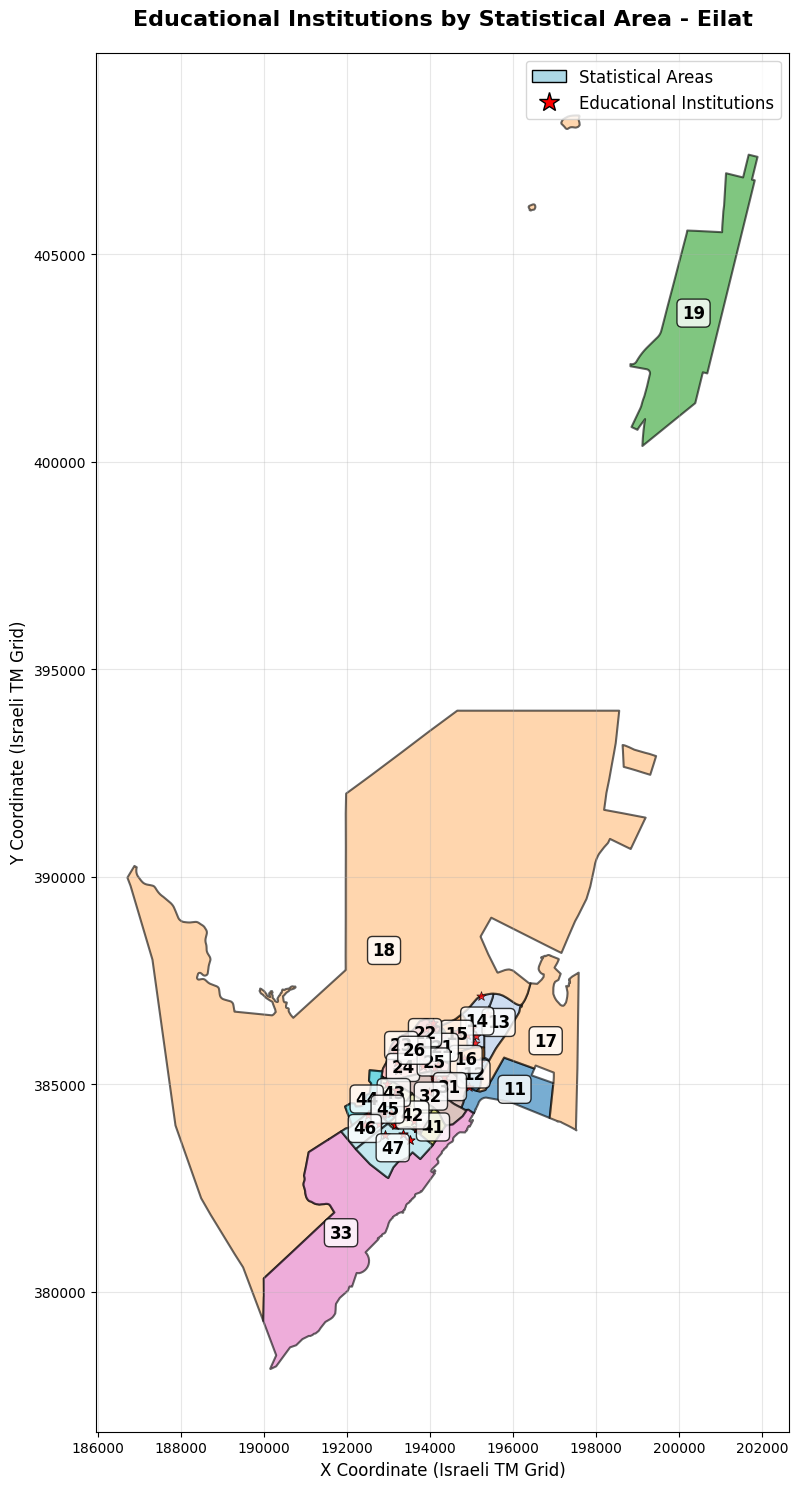


Map legend:
  - Colored polygons = Statistical areas (numbered)
  - Red stars = Educational institutions
  - Total: 128 institutions across 25 statistical areas


In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("Creating map visualization...\n")

# Create figure with larger size
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot statistical areas (polygons)
gdf_areas.plot(
    ax=ax,
    column='STAT_2022',
    cmap='tab20',  # Color map with distinct colors
    edgecolor='black',
    linewidth=1.5,
    alpha=0.6,
    legend=False
)

# Add statistical area labels (numbers) at the centroid of each polygon
for idx, row in gdf_areas.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x,
        centroid.y,
        str(int(row['STAT_2022'])),
        fontsize=12,
        fontweight='bold',
        ha='center',
        va='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.8)
    )

# Plot institutions (points)
gdf_institutions_transformed.plot(
    ax=ax,
    color='red',
    markersize=50,
    marker='*',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.8,
    label='Educational Institutions'
)

# Set title and labels
ax.set_title('Educational Institutions by Statistical Area - Eilat',
              fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('X Coordinate (Israeli TM Grid)', fontsize=12)
ax.set_ylabel('Y Coordinate (Israeli TM Grid)', fontsize=12)

# Add legend
legend_elements = [
    mpatches.Patch(facecolor='lightblue', edgecolor='black', label='Statistical Areas'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red',
               markersize=15, markeredgecolor='black', label='Educational Institutions')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Map legend:")
print("  - Colored polygons = Statistical areas (numbered)")
print("  - Red stars = Educational institutions")
print(f"  - Total: {len(gdf_institutions_transformed)} institutions across {gdf_areas['STAT_2022'].nunique()} statistical areas")

In [23]:
!pip install folium

In [24]:
import folium
from folium import plugins

print("Creating interactive map with Folium...\n")

# Convert back to WGS84 (lat/lon) for Folium
gdf_areas_wgs84 = gdf_areas.to_crs('EPSG:4326')
gdf_institutions_wgs84 = gdf_institutions  # Already in EPSG:4326

# Calculate center of Eilat for the map
center_lat = gdf_institutions_wgs84['lat'].mean()
center_lon = gdf_institutions_wgs84['lon'].mean()

print(f"Map center: {center_lat:.6f}, {center_lon:.6f}")

# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=13,
    tiles='OpenStreetMap'
)

# Add statistical area polygons with colors
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
          'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
          'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray',
          'yellow', 'lightpink', 'olive', 'teal', 'navy', 'brown']

print("Adding statistical areas to map...")

for idx, row in gdf_areas_wgs84.iterrows():
    stat_code = int(row['STAT_2022'])
    color = colors[idx % len(colors)]

    # Count institutions in this area
    inst_count = len(result[result['STAT_2022'] == stat_code])

    # Create popup text
    popup_text = f"""
    <b>Statistical Area: {stat_code}</b><br>
    Institutions: {inst_count}<br>
    Area: {row['Shape__Are']:.0f} m²
    """

    folium.GeoJson(
        row.geometry,
        style_function=lambda x, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 2,
            'fillOpacity': 0.4
        },
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

    # Add label at centroid
    centroid = row.geometry.centroid
    folium.Marker(
        location=[centroid.y, centroid.x],
        icon=folium.DivIcon(html=f"""
            <div style="
                font-size: 14px;
                font-weight: bold;
                color: black;
                background-color: white;
                border: 2px solid black;
                border-radius: 5px;
                padding: 2px 5px;
                text-align: center;
            ">{stat_code}</div>
        """)
    ).add_to(m)

print("Adding educational institutions to map...")

# Add institutions as markers
for idx, row in result.iterrows():
    popup_text = f"""
    <b>{row['Institution name']}</b><br>
    Code: {row['Institution Code']}<br>
    Address: {row['address']}<br>
    Type: {row['type of education']}<br>
    Phase: {row['education phase']}<br>
    <b>Statistical Area: {int(row['STAT_2022'])}</b>
    """

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=6,
        popup=folium.Popup(popup_text, max_width=300),
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.8,
        weight=2
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save and display
print("\nSaving map...")
m.save('eilat_institutions_map.html')
print("✓ Map saved as: eilat_institutions_map.html")

# Download the map
files.download('eilat_institutions_map.html')

print("\n✓✓✓ Interactive map created!")
print("\nMap features:")
print("  - Click on polygons to see statistical area info")
print("  - Click on red circles to see institution details")
print("  - Zoom and pan to explore")
print("  - Numbers show statistical area codes")

# Display the map in the notebook
m

Creating interactive map with Folium...

Map center: 29.554391, 34.939025
Adding statistical areas to map...
Adding educational institutions to map...

Saving map...
✓ Map saved as: eilat_institutions_map.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓✓✓ Interactive map created!

Map features:
  - Click on polygons to see statistical area info
  - Click on red circles to see institution details
  - Zoom and pan to explore
  - Numbers show statistical area codes


In [25]:
print("Preparing final dataset for export...\n")

# Create a clean dataframe with the stat_2022 column
final_data = educational_institutions.copy()

# Add the stat_2022 column from the spatial join result
final_data['stat_2022'] = result['STAT_2022'].values

# Convert stat_2022 to integer (remove np.int32 wrapper)
final_data['stat_2022'] = final_data['stat_2022'].astype(int)

# Reorder columns to put stat_2022 after the location columns
columns_order = [
    'Institution Code',
    'Institution name',
    'address',
    'type of supervision',
    'type of education',
    'education phase',
    'full_address',
    'lat',
    'lon',
    'stat_2022'  # New foreign key column
]

final_data = final_data[columns_order]

print("="*80)
print("Final dataset preview:")
print(final_data.head(15))

print("\n" + "="*80)
print("Summary:")
print(f"✓ Total institutions: {len(final_data)}")
print(f"✓ Columns: {len(final_data.columns)}")
print(f"✓ New 'stat_2022' column added (foreign key to statistical areas)")

# Show value counts
print("\n" + "="*80)
print("Distribution of institutions by statistical area:")
print(final_data['stat_2022'].value_counts().sort_index())

# Export to Excel
print("\n" + "="*80)
print("Exporting files...")

output_filename = 'Eilat_educational_institutions_with_stat_2022.xlsx'
final_data.to_excel(output_filename, index=False, engine='openpyxl')
print(f"✓ Excel file created: {output_filename}")

# Also export as CSV (with UTF-8 encoding for Hebrew text)
csv_filename = 'Eilat_educational_institutions_with_stat_2022.csv'
final_data.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"✓ CSV file created: {csv_filename}")

print("\n" + "="*80)
print("Downloading files...")

# Download both files
files.download(output_filename)
files.download(csv_filename)

print("\n✓✓✓ SUCCESS! Files downloaded!")
print("\nYou now have:")
print("  1. Excel file with stat_2022 foreign key column")
print("  2. CSV file with stat_2022 foreign key column")
print("  3. Interactive HTML map")

Preparing final dataset for export...

Final dataset preview:
    Institution Code Institution name         address type of supervision  \
0             678813             אביב   עונות השנה 11               State   
1             533158            אביבה   עין נטפים 128     State religious   
2             604314           אביבית  משעול החמנית 7               State   
3             136135             אדום       הנבטים 22               State   
4             533273              אור        גרופית 4               State   
5             665000             אילת    החשמונאים 11               State   
6             159905            ארגמן   עין עקרבים 19               State   
7             462754            ארנון       התמרים 51               State   
8             604843            אשלים         האשלג 3               State   
9             116038             ברקן          דקר 35               State   
10            678805             ברקת         נחשון 7               State   
11            

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓✓✓ SUCCESS! Files downloaded!

You now have:
  1. Excel file with stat_2022 foreign key column
  2. CSV file with stat_2022 foreign key column
  3. Interactive HTML map
